In [1]:
# RGB-D Object Dataset: https://rgbd-dataset.cs.washington.edu/dataset/rgbd-scenes_aligned/

In [2]:
# download data: RGB point cloud
# !wget https://rgbd-dataset.cs.washington.edu/dataset/rgbd-scenes_aligned/table_small_1.tar
# !mkdir -p data
# !tar -xf table_small_1.tar -C data

## Reprojection example
Here there are 2 examples of reprojection image from one camera view to another camera view. <br>
2 examples: Pinhole camera and Fisheye camera model.

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
from reprojection import (
    BackprojectDepth,
    Project3D,
    FisheyeBackprojDepth,
    FisheyeProj,
    reproject_images
)
from utils import (
    open_calib,
    get_4x4tranform,
    cloud_projection,
)

In [5]:
# save .pcd as .npy
# import open3d as o3d
# cloud = o3d.io.read_point_cloud(PATH + "table_small_1.pcd")
# points = np.asarray(cloud.points)
# colors = np.asarray(cloud.colors)
# np.save("./data/points.npy", points)
# np.save("./data/colors.npy", colors)

In [6]:
PATH = "./data/rgbd-scenes_aligned/table_small/table_small_1/"
calib = open_calib('calib.json')
points = np.load("./data/points.npy")
colors = np.load("./data/colors.npy")

## Pinhole reprojection

In [7]:
# project RGB point cloud
calib_curr = calib["pinhole_1"]
calib_prev = calib["pinhole_2"]
rgb_imgs_curr_np, depth_maps_curr_np = cloud_projection(points, colors, calib_curr)
rgb_imgs_prev_np, depth_maps_prev_np = cloud_projection(points, colors, calib_prev)

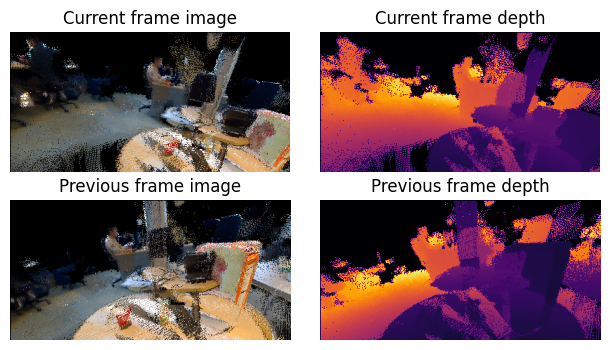

In [8]:
def plot_img(ax, img, name=False, depth=False):
    ax.imshow(img, cmap="inferno")
    ax.axis('off')
    if name:
        ax.set_title(name)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 4))
fig.subplots_adjust(wspace = 0)
plot_img(ax[0, 0], rgb_imgs_curr_np[0], name="Current frame image")
plot_img(ax[0, 1], depth_maps_curr_np[0], name="Current frame depth")
plot_img(ax[1, 0], rgb_imgs_prev_np[0], name="Previous frame image")
plot_img(ax[1, 1], depth_maps_prev_np[0], name="Previous frame depth")

In [9]:
# prepare data for reprojection
# imgs/maps
depth_maps_curr = torch.from_numpy(depth_maps_curr_np.astype(np.float32))
rgb_imgs_prev  = torch.from_numpy(rgb_imgs_prev_np.astype(np.float32)).permute(0, 3, 1, 2)
# transforms
batch_K = torch.from_numpy(calib_curr["K"].astype(np.float32)).unsqueeze(0)
batch_frame_transform = torch.eye(4, dtype=torch.float64).unsqueeze(0)
batch_ego2cam = get_4x4tranform(calib_curr["R"], calib_curr["T"]).inverse()
batch_cam2ego = get_4x4tranform(calib_prev["R"], calib_prev["T"])
# funcs
w_img, h_img = calib_curr["image_size"]
proj, back_proj = Project3D(1, int(h_img), int(w_img)), BackprojectDepth(1, int(h_img), int(w_img))

In [10]:
# reprojection
reproj_rgb, reproj_masks = reproject_images(
    depth_maps_curr,
    rgb_imgs_prev,
    batch_K,
    batch_frame_transform,
    batch_ego2cam,
    batch_cam2ego,
    proj,
    back_proj,
)

In [11]:
reproj_rgb_img = reproj_rgb[0].permute(1, 2, 0)
common_mask = ((reproj_masks[0] != 0) & (depth_maps_curr_np[0] != 0))[..., None]

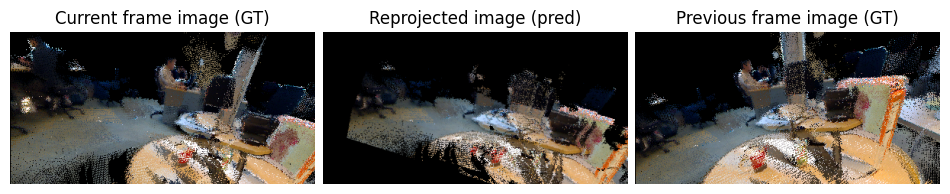

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 10))
fig.subplots_adjust(wspace = 0.025)
plot_img(ax[0], rgb_imgs_curr_np[0], name="Current frame image (GT)")
plot_img(ax[1], reproj_rgb_img * common_mask, name="Reprojected image (pred)")
plot_img(ax[2], rgb_imgs_prev_np[0], name="Previous frame image (GT)")

## Fisheye reprojection

In [13]:
# project RGB point cloud
calib_curr = calib["fisheye_1"]
calib_prev = calib["fisheye_2"]
rgb_imgs_curr_np, depth_maps_curr_np = cloud_projection(points, colors, calib_curr, fisheye=True)
rgb_imgs_prev_np, depth_maps_prev_np = cloud_projection(points, colors, calib_prev, fisheye=True)

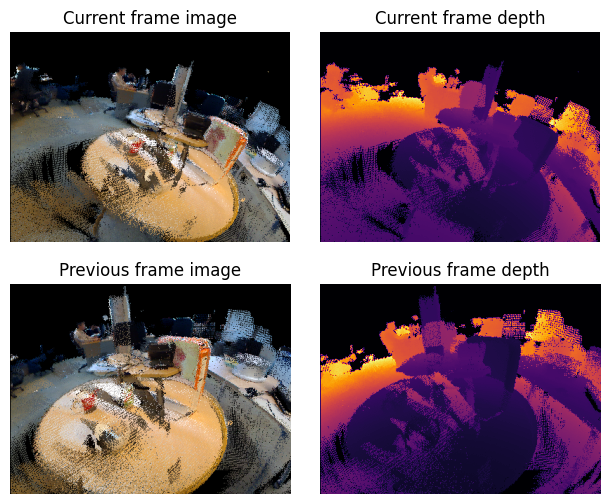

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
fig.subplots_adjust(wspace = 0)
plot_img(ax[0, 0], rgb_imgs_curr_np[0], name="Current frame image")
plot_img(ax[0, 1], depth_maps_curr_np[0], name="Current frame depth")
plot_img(ax[1, 0], rgb_imgs_prev_np[0], name="Previous frame image")
plot_img(ax[1, 1], depth_maps_prev_np[0], name="Previous frame depth")

In [15]:
# prepare data for reprojection
# imgs/maps
depth_maps_curr = torch.from_numpy(depth_maps_curr_np.astype(np.float32))
rgb_imgs_prev  = torch.from_numpy(rgb_imgs_prev_np.astype(np.float32)).permute(0, 3, 1, 2)
# transforms
batch_K = torch.from_numpy(calib_curr["K"].astype(np.float32)).unsqueeze(0)
batch_frame_transform = torch.eye(4, dtype=torch.float64).unsqueeze(0)
batch_ego2cam = get_4x4tranform(calib_curr["R"], calib_curr["T"]).inverse()
batch_cam2ego = get_4x4tranform(calib_prev["R"], calib_prev["T"])
batch_distortion = torch.from_numpy(calib_curr["distortion"]).unsqueeze(0)
# funcs
w_img, h_img = calib_curr["image_size"]
proj, back_proj = FisheyeProj(1, int(h_img), int(w_img)), FisheyeBackprojDepth(1, int(h_img), int(w_img))

In [16]:
# reprojection
reproj_rgb, reproj_masks = reproject_images(
    depth_maps_curr,
    rgb_imgs_prev,
    batch_K,
    batch_frame_transform,
    batch_ego2cam,
    batch_cam2ego,
    proj,
    back_proj,
    batch_distortion,
    is_fisheye=True
)

In [17]:
reproj_rgb_img = reproj_rgb[0].permute(1, 2, 0)
common_mask = ((reproj_masks[0] != 0) & (depth_maps_curr_np[0] != 0))[..., None]

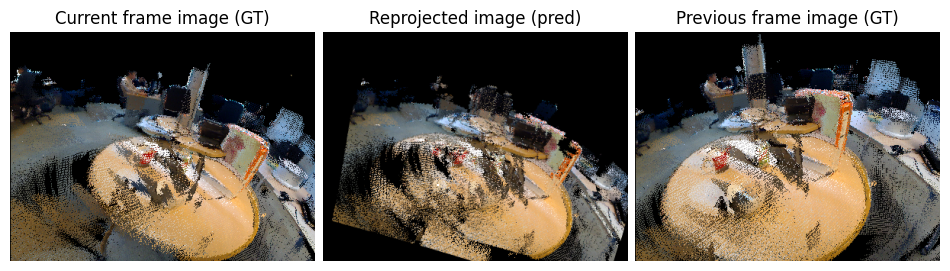

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 10))
fig.subplots_adjust(wspace = 0.025)
plot_img(ax[0], rgb_imgs_curr_np[0], name="Current frame image (GT)")
plot_img(ax[1], reproj_rgb_img * common_mask, name="Reprojected image (pred)")
plot_img(ax[2], rgb_imgs_prev_np[0], name="Previous frame image (GT)")